# NOAA NCEI Integrated Surface Dataset (Global)
### Precipitation Data (Hourly) from 2010 to 2020, LAGUARDIA AIRPORT, NY US

Mark Bauer

Dataset link: https://www.ncei.noaa.gov/access/search/data-search/global-hourly  
Data dictionary: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

# 1. Importing Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.23.1
pandas           : 1.4.3
geopandas        : 0.11.1
geoplot          : 0.5.1
fiona            : 1.8.21
matplotlib.pyplot: unknown
seaborn          : 0.11.2



Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

Attribute information:

> LIQUID-PRECIPITATION occurrence identifier  
 The identifier that represents an episode of LIQUID-PRECIPITATION.
 DOM: A specific domain comprised of the characters in the ASCII character set.  
 AA1 - AA4 An indicator of up to 4 repeating fields of the following items:  
 LIQUID-PRECIPITATION period quantity  
 LIQUID-PRECIPITATION depth dimension  
 LIQUID-PRECIPITATION condition code  
 LIQUID-PRECIPITATION quality code

In [4]:
# list items in data folder
%ls ../../Downloads/asos-isd/

72503014732 (1).csv      72503014732 (4).csv      72503014732 (8).csv
72503014732 (10).csv     72503014732 (5).csv      72503014732 (9).csv
72503014732 (2).csv      72503014732 (6).csv      72503014732.csv
72503014732 (3).csv      72503014732 (7).csv      isd-format-document.pdf


In [5]:
path = '../../Downloads/asos-isd'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file, low_memory=False) for file in csv_files)
df = pd.concat(df_list, ignore_index=True)

print(df.shape)
df.head()

(151890, 106)


,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,RH3,REM,EQD,AT7,AT8,MW2,MW3,GA4,GA5,GA6
0,72503014732,2017-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,...,NaN,SYN08672503 32866 82015 10067 21028 30132 4014...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72503014732,2017-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,...,NaN,MET11112/31/16 19:51:03 METAR KLGA 010051Z 220...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72503014732,2017-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,...,NaN,MET10412/31/16 20:51:03 METAR KLGA 010151Z 210...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72503014732,2017-01-01T02:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,...,NaN,MET10712/31/16 21:51:03 METAR KLGA 010251Z 200...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72503014732,2017-01-01T03:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,...,NaN,SYN06472503 32966 82010 10067 21044 30115 4012...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[['STATION', 'DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
    'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 
    'AA1']]

df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1
0,72503014732,2017-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN
1,72503014732,2017-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5"
2,72503014732,2017-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5"
3,72503014732,2017-01-01T02:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5"
4,72503014732,2017-01-01T03:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN


In [7]:
df = pd.concat([df, df['AA1'].str.split(",", expand = True)], axis=1)

df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,0,1,2,3
0,72503014732,2017-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN
1,72503014732,2017-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
2,72503014732,2017-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
3,72503014732,2017-01-01T02:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
4,72503014732,2017-01-01T03:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN


In [8]:
df.columns = ['STATION', 'DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
              'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 
              'AA1', 'period_quantity_hr', 'depth_dimension_mm', 'condition_code', 'quality_code']

df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,period_quantity_hr,depth_dimension_mm,condition_code,quality_code
0,72503014732,2017-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN
1,72503014732,2017-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
2,72503014732,2017-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
3,72503014732,2017-01-01T02:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",01,0000,9,5
4,72503014732,2017-01-01T03:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN


In [9]:
cols = df.columns[-4:]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151890 entries, 0 to 151889
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STATION             151890 non-null  int64  
 1   DATE                151890 non-null  object 
 2   SOURCE              151890 non-null  int64  
 3   LATITUDE            151890 non-null  float64
 4   LONGITUDE           151890 non-null  float64
 5   ELEVATION           151890 non-null  float64
 6   NAME                151890 non-null  object 
 7   REPORT_TYPE         151890 non-null  object 
 8   CALL_SIGN           151890 non-null  object 
 9   QUALITY_CONTROL     151890 non-null  object 
 10  AA1                 117550 non-null  object 
 11  period_quantity_hr  117550 non-null  float64
 12  depth_dimension_mm  117550 non-null  float64
 13  condition_code      117550 non-null  float64
 14  quality_code        117447 non-null  float64
dtypes: float64(7), int64(2), object(6)

In [10]:
df.describe()

,STATION,SOURCE,LATITUDE,LONGITUDE,ELEVATION,period_quantity_hr,depth_dimension_mm,condition_code,quality_code
count,1.518900e+05,151890.000000,1.518900e+05,1.518900e+05,1.518900e+05,117550.000000,117550.000000,117550.000000,117447.000000
mean,7.250301e+10,6.322773,4.077944e+01,-7.388035e+01,3.400000e+00,2.117269,5.443964,7.834419,4.408414
std,0.000000e+00,1.218478,1.421090e-14,2.842180e-14,8.881813e-16,4.512482,70.543646,2.532255,1.423744
min,7.250301e+10,4.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.000000,0.000000,2.000000,1.000000
25%,7.250301e+10,6.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.000000,0.000000,9.000000,5.000000
50%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.000000,0.000000,9.000000,5.000000
75%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.000000,0.000000,9.000000,5.000000
max,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,24.000000,9999.000000,9.000000,9.000000


In [11]:
df.loc[df['period_quantity_hr'] > 1, ['period_quantity_hr']] = np.nan
df.loc[df['depth_dimension_mm'] == 9999, ['depth_dimension_mm']] = np.nan

df.describe()

,STATION,SOURCE,LATITUDE,LONGITUDE,ELEVATION,period_quantity_hr,depth_dimension_mm,condition_code,quality_code
count,1.518900e+05,151890.000000,1.518900e+05,1.518900e+05,1.518900e+05,105995.0,117545.000000,117550.000000,117447.000000
mean,7.250301e+10,6.322773,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,5.018869,7.834419,4.408414
std,0.000000e+00,1.218478,1.421090e-14,2.842180e-14,8.881813e-16,0.0,26.985017,2.532255,1.423744
min,7.250301e+10,4.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,2.000000,1.000000
25%,7.250301e+10,6.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,9.000000,5.000000
50%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,9.000000,5.000000
75%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,9.000000,5.000000
max,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,1676.000000,9.000000,9.000000


In [12]:
df['depth_dimension_in'] = df['depth_dimension_mm'] / 25.4

df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,period_quantity_hr,depth_dimension_mm,condition_code,quality_code,depth_dimension_in
0,72503014732,2017-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN,NaN
1,72503014732,2017-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",1.0,0.0,9.0,5.0,0.0
2,72503014732,2017-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",1.0,0.0,9.0,5.0,0.0
3,72503014732,2017-01-01T02:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",1.0,0.0,9.0,5.0,0.0
4,72503014732,2017-01-01T03:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,99999,V020,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df['date_time'] = pd.to_datetime(df['DATE'], infer_datetime_format=True)
df = df.sort_values(by='date_time').reset_index(drop=True)

df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,period_quantity_hr,depth_dimension_mm,condition_code,quality_code,depth_dimension_in,date_time
0,72503014732,2010-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,KLGA,V020,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:00:00
1,72503014732,2010-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",1.0,0.0,9.0,5.0,0.00000,2010-01-01 00:51:00
2,72503014732,2010-01-01T01:36:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-16,KLGA,V030,"01,0000,2,1",1.0,0.0,2.0,1.0,0.00000,2010-01-01 01:36:00
3,72503014732,2010-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0003,9,5",1.0,3.0,9.0,5.0,0.11811,2010-01-01 01:51:00
4,72503014732,2010-01-01T02:01:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-16,KLGA,V030,"01,0003,9,1",1.0,3.0,9.0,1.0,0.11811,2010-01-01 02:01:00


In [14]:
df = df[['STATION', 'date_time', 'DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
         'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 
         'AA1', 
         'period_quantity_hr', 
         'depth_dimension_mm', 'depth_dimension_in', 
         'condition_code','quality_code']]

df.head()

,STATION,date_time,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,period_quantity_hr,depth_dimension_mm,depth_dimension_in,condition_code,quality_code
0,72503014732,2010-01-01 00:00:00,2010-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-12,KLGA,V020,NaN,NaN,NaN,NaN,NaN,NaN
1,72503014732,2010-01-01 00:51:00,2010-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0000,9,5",1.0,0.0,0.00000,9.0,5.0
2,72503014732,2010-01-01 01:36:00,2010-01-01T01:36:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-16,KLGA,V030,"01,0000,2,1",1.0,0.0,0.00000,2.0,1.0
3,72503014732,2010-01-01 01:51:00,2010-01-01T01:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-15,KLGA,V030,"01,0003,9,5",1.0,3.0,0.11811,9.0,5.0
4,72503014732,2010-01-01 02:01:00,2010-01-01T02:01:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",FM-16,KLGA,V030,"01,0003,9,1",1.0,3.0,0.11811,9.0,1.0


In [15]:
df.describe()

,STATION,SOURCE,LATITUDE,LONGITUDE,ELEVATION,period_quantity_hr,depth_dimension_mm,depth_dimension_in,condition_code,quality_code
count,1.518900e+05,151890.000000,1.518900e+05,1.518900e+05,1.518900e+05,105995.0,117545.000000,117545.000000,117550.000000,117447.000000
mean,7.250301e+10,6.322773,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,5.018869,0.197593,7.834419,4.408414
std,0.000000e+00,1.218478,1.421090e-14,2.842180e-14,8.881813e-16,0.0,26.985017,1.062402,2.532255,1.423744
min,7.250301e+10,4.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,0.000000,2.000000,1.000000
25%,7.250301e+10,6.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,0.000000,9.000000,5.000000
50%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,0.000000,9.000000,5.000000
75%,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,0.000000,0.000000,9.000000,5.000000
max,7.250301e+10,7.000000,4.077944e+01,-7.388035e+01,3.400000e+00,1.0,1676.000000,65.984252,9.000000,9.000000


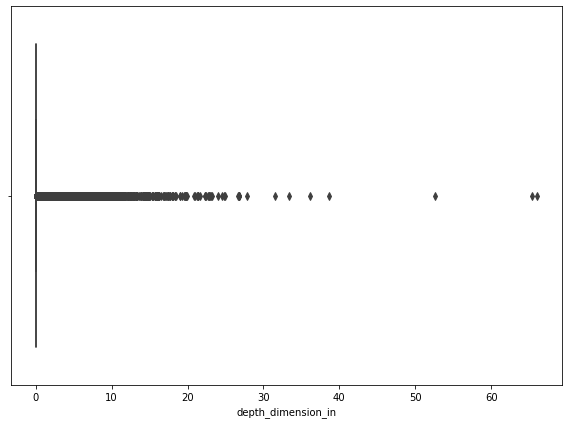

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x=df["depth_dimension_in"], ax=ax)
plt.tight_layout()

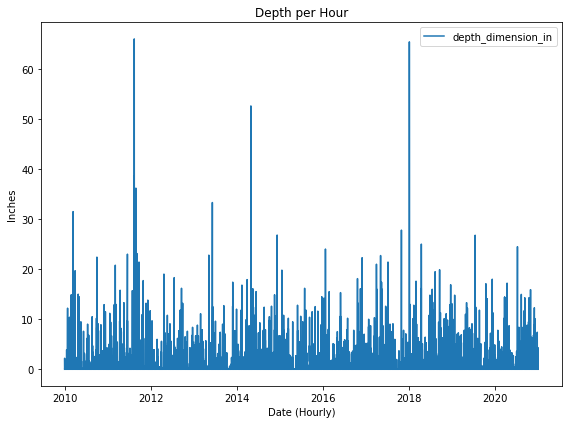

In [17]:
plt.figure(figsize=(8, 6))

plot_df = df.set_index(df['date_time']).loc[:, ['depth_dimension_in']]

sns.lineplot(data=plot_df)

plt.title('Depth per Hour')
plt.xlabel('Date (Hourly)')
plt.ylabel('Inches')
plt.tight_layout()

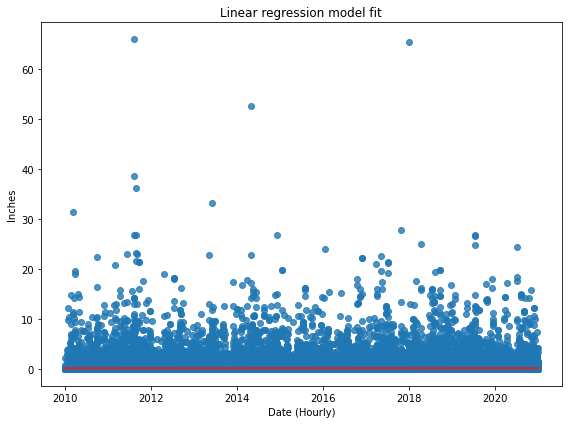

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.xaxis.update_units(df['date_time'])
sns.regplot(x=ax.xaxis.convert_units(df['date_time']),
            y=df['depth_dimension_in'],
            scatter_kws={"color": "tab:blue"},
            line_kws={"color": "tab:red"})

plt.title('Linear regression model fit')
plt.xlabel('Date (Hourly)')
plt.ylabel('Inches')

plt.tight_layout()